# Learning to optimize parametric nonlinear programming problem (pNLP) using differentiable projected gradient method in Neuromancer.


This is an interactive notebook based on the python script [Part_4_projectedGradient.py](./Part_4_projectedGradient.py).  

We demonstrate how the NeuroMANCER toolbox can be used to solve parametric constrained [Rosenbrock problem](https://en.wikipedia.org/wiki/Rosenbrock_function):

$$
\begin{align}
&\text{minimize } &&  (1-x)^2 + a(y-x^2)^2\\
&\text{subject to} && \left(\frac{p}{2}\right)^2 \le x^2 + y^2 \le p^2\\
& && x \ge y
\end{align}
$$

with parameters $p, a$ and decision variables $x, y$.

References:  
    [projected gradient method](https://neos-guide.org/guide/algorithms/gradient-projection/)  
    [Deep Constraint Completion and Correction (DC3) paper](https://arxiv.org/abs/2104.12225)

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [1]:
!pip install neuromancer

*Note: When running on Colab, one might encounter a pip dependency error with Lida 0.0.10. This can be ignored*

### Import

In [2]:
import torch
import torch.nn as nn
import numpy as np
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from casadi import *
import casadi
import time

C:\Users\drgon\anaconda3\envs\neuromancer-dev\lib\site-packages\mlflow\utils\requirements_utils.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks, solvers
from neuromancer.system import Node

# Dataset

In [4]:
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed);

Randomly sample parameters from a uniform distribution: $0.5\le p\le2.0$;  $0.2\le a\le1.2$

In [5]:
nsim = 5000  # number of datapoints: increase sample density for more robust results
# create dictionaries with sampled datapoints with uniform distribution
a_low, a_high, p_low, p_high = 0.2, 1.2, 0.5, 2.0
samples_train = {"a": torch.FloatTensor(nsim, 1).uniform_(a_low, a_high),
                 "p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev = {"a": torch.FloatTensor(nsim, 1).uniform_(a_low, a_high),
               "p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test = {"a": torch.FloatTensor(nsim, 1).uniform_(a_low, a_high),
               "p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle

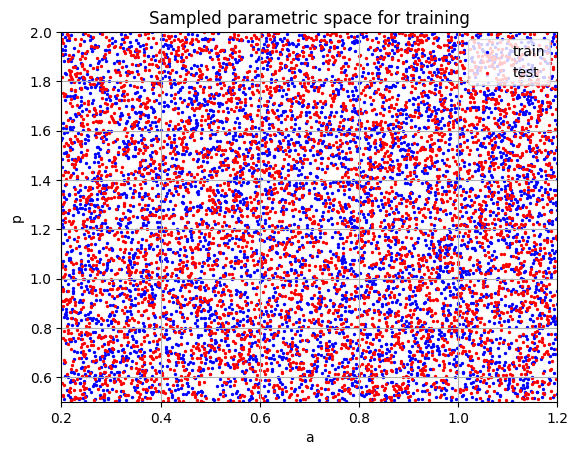

In [6]:
# visualize taining and test samples for 2D parametric space
a_train = samples_train['a'].numpy()
p_train = samples_train['p'].numpy()
a_dev = samples_dev['a'].numpy()
p_dev = samples_dev['p'].numpy()
plt.figure()
plt.scatter(a_train, p_train, s=2., c='blue', marker='o')
plt.scatter(a_dev, p_dev, s=2., c='red', marker='o')
plt.title('Sampled parametric space for training')
plt.xlim(a_low, a_high)
plt.ylim(p_low, p_high)
plt.grid(True)
plt.xlabel('a')
plt.ylabel('p')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.show(block=True)

# pNLP Formulation in NeuroMANCER

## Primal Solution Map Architecture

we define symbolic wrapper for a neural network architecture creating a mapping of problem parameters $a, p$ onto decision variables $x$:  
$x = net(a, p)$



In [7]:
# define neural architecture for the trainable solution map
func = blocks.MLP(insize=2, outsize=2,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[80] * 4)
# wrap neural net into symbolic representation of the solution map via the Node class: sol_map(xi) -> x
sol_map = Node(func, ['a', 'p'], ['x'], name='map')

## Objective and Constraints in NeuroMANCER

construct symbolic objectives and constraints of the problem:  
$$
\begin{align}
&\text{minimize } &&  (1-x)^2 + a(y-x^2)^2\\
&\text{subject to} && \left(\frac{p}{2}\right)^2 \le x^2 + y^2 \le p^2\\
& && x \ge y
\end{align}
$$

In [8]:
"""
variable is a basic symbolic abstraction in Neuromancer
   x = variable("variable_name")                      (instantiates new variable)  
variable construction supports:
   algebraic expressions:     x**2 + x**3 + 5     (instantiates new variable)  
   slicing:                   x[:, i]             (instantiates new variable)  
   pytorch callables:         torch.sin(x)        (instantiates new variable)  
   constraints definition:    x <= 1.0            (instantiates Constraint object) 
   objective definition:      x.minimize()        (instantiates Objective object) 
to visualize computational graph of the variable use x.show() method          
"""

# define primal decision variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# problem parameters sampled in the dataset
p = variable('p')
a = variable('a')

# objective function
f = (1-x)**2 + a*(y-x**2)**2
obj = f.minimize(weight=1.0, name='obj')

# constraints
Q_con = 1.0  # constraint penalty weights set deliberately too low to demonstrate 
con_1 = Q_con*(x >= y)
con_2 = Q_con*((p/2)**2 <= x**2+y**2)
con_3 = Q_con*(x**2+y**2 <= p**2)
con_1.name = 'c1'
con_2.name = 'c2'
con_3.name = 'c3'

## Differentiable projected gradient layer

use unrolled gradient projection algorithm as a layer in the symbolic computational graph correcting the initial solution from the neural network:  
$$
x = net(a, p)  \\
x_{\text{projected}} = GradientProjection(x) 
$$

the $GradientProjection$ layer implements a simple iterative algorithm for constraints correction:  
$$
x_{projected} = x - \alpha \nabla \ell(g(x))
$$  
where $g(x)$ represents a left hand side of the inequality constraints in the standard form:  
$$g(x) \le 0$$  
$\ell(\cdot)$ defines the constraints violation penalty, for instance given as:  
$$
\ell(\cdot) = || \text{ReLU}(\cdot)  ||_2^2
$$  
and $\alpha$ gives the step size. For better convergence the method can be used over multiple steps $k$ with varying stepsize $\alpha_k$, e.g. by using momentum.  

For further details see the [Neuromancer implementation](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/modules/solvers.py#L45) or the [Deep Constraint Completion and Correction (DC3) paper](https://arxiv.org/abs/2104.12225).

In [9]:
# instantiate projected gradient layer to correct the solutions from the neural net:
# proj(sol_map(xi)) -> x
num_steps = 5
step_size = 0.1
proj = solvers.GradientProjection(constraints=[con_2, con_3],          # inequality constraints to be corrected
                                  input_keys=["x"],                    # primal variables to be updated
                                  num_steps=num_steps,                 # number of rollout steps of the solver method
                                  step_size=step_size,                 # step size of the solver method
                                  decay=0.1,                           # decay factor of the step size
                                  name='proj')

## Construct differentiable optimization problem

Putting things together in a single differentiable symbolic computational graph constructed via Neuromancer's [Problem class](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/problem.py#L18) using [differentiable loss functions](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/loss.py).

In [10]:
# constrained optimization problem construction
objectives = [obj]
constraints = [con_1, con_2, con_3]
components = [sol_map, proj]
    
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss,
                  grad_inference=True   # argument for allowing computation of gradients at the inference time
                  )
# problem.show()

## Parametric Problem Solution in NeuroMANCER

In [11]:
lr = 0.001      # step size for gradient descent
epochs = 50    # number of training epochs
warmup = epochs    # number of epochs to wait before enacting early stopping policy
patience = epochs  # number of epochs with no improvement in eval metric to allow before early stopping

In [12]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup)

In [13]:
# Train NLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

epoch: 0  train_loss: 0.13619667291641235
epoch: 1  train_loss: 0.05767969414591789
epoch: 2  train_loss: 0.052668966352939606
epoch: 3  train_loss: 0.05183699354529381
epoch: 4  train_loss: 0.051352038979530334
epoch: 5  train_loss: 0.05091703310608864
Interrupted training loop.


<All keys matched successfully>

## Get pNLP solution from trained neural network

In [14]:
# selected problem parameters
p = 1.0
a = 1.0

In [15]:
# Solution to mpNLP via Neuromancer
datapoint = {'a': torch.tensor([[a]]), 'p': torch.tensor([[p]]),
             'name': 'test'}
model_out = problem(datapoint)
x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
print(x_nm)
print(y_nm)

0.80091256
0.5662299


## Get pNLP solution from CasADi for comparison

[CasADi](https://web.casadi.org/) is an open-source tool for constrained optimization and optimal control that has influenced the development of NeuroMANCER.

In [16]:
# instantiate casadi optimizaiton problem class
def NLP_param(a, p, opti_silent=False):
    opti = casadi.Opti()
    # define variables
    x = opti.variable()
    y = opti.variable()
    p_opti = opti.parameter()
    a_opti = opti.parameter()
    # define objective and constraints
    opti.minimize((1 - x) ** 2 + a_opti * (y - x ** 2) ** 2)
    opti.subject_to(x >= y)
    opti.subject_to((p_opti / 2) ** 2 <= x ** 2 + y ** 2)
    opti.subject_to(x ** 2 + y ** 2 <= p_opti ** 2)
    # select IPOPT solver and solve the NLP
    if opti_silent:
        opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
    else:
        opts = {}
    opti.solver('ipopt', opts)
    # set parametric values
    opti.set_value(p_opti, p)
    opti.set_value(a_opti, a)
    return opti, x, y

# construct casadi problem
opti, x, y = NLP_param(a, p)
# solve NLP via casadi
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [17]:
print(f"x = {sol.value(x)}")
print(f"y = {sol.value(y)}")

x = 0.8081695826847699
y = 0.588949838491767


## Compare: NeuroMANCER vs. CasADi

When training the neural network, we choose deliberately bad tuning of the constraints penalties to illustrate the correction mechanism of the projected gradient method.

0.80091256
0.5662299


C:\Users\drgon\AppData\Local\Temp\ipykernel_42540\2432087878.py:22: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if hasattr(cg1, 'collections') and cg1.collections:
C:\Users\drgon\AppData\Local\Temp\ipykernel_42540\2432087878.py:23: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  plt.setp(cg1.collections,
C:\Users\drgon\AppData\Local\Temp\ipykernel_42540\2432087878.py:27: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if hasattr(cg2, 'collections') and cg2.collections:
C:\Users\drgon\AppData\Local\Temp\ipykernel_42540\2432087878.py:28: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  plt.setp(cg2.collections,
C:\Users\drgon\AppData\Local\Temp\ipykernel_42540\2432087878.py:32: MatplotlibDeprecationWar

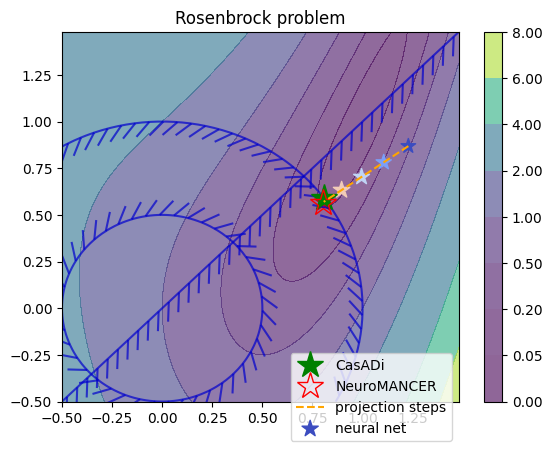

In [18]:
"""
Plots
"""
x1 = np.arange(-0.5, 1.5, 0.02)
y1 = np.arange(-0.5, 1.5, 0.02)
xx, yy = np.meshgrid(x1, y1)

# eval objective and constraints
J = (1 - xx) ** 2 + a * (yy - xx ** 2) ** 2
c1 = xx - yy
c2 = xx ** 2 + yy ** 2 - (p / 2) ** 2
c3 = -(xx ** 2 + yy ** 2) + p ** 2

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(xx, yy, J,
                 levels=[0, 0.05, 0.2, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0],
                 alpha=0.6)
fig.colorbar(cp)
ax.set_title('Rosenbrock problem')

cg1 = ax.contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
if hasattr(cg1, 'collections') and cg1.collections:
    plt.setp(cg1.collections,
            path_effects=[patheffects.withTickedStroke()], alpha=0.7)

cg2 = ax.contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
if hasattr(cg2, 'collections') and cg2.collections:
    plt.setp(cg2.collections,
            path_effects=[patheffects.withTickedStroke()], alpha=0.7)

cg3 = ax.contour(xx, yy, c3, [0], colors='mediumblue', alpha=0.7)
if hasattr(cg3, 'collections') and cg3.collections:
    plt.setp(cg3.collections,
            path_effects=[patheffects.withTickedStroke()], alpha=0.7)

# Solution to pNLP via Neuromancer
datapoint = {'a': torch.tensor([[a]]), 'p': torch.tensor([[p]]),
             'name': 'test'}
model_out = problem(datapoint)
x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
print(x_nm)
print(y_nm)

# intermediate projection steps
x_proj = sol_map(datapoint)
proj.num_steps = 1    # set projections steps to 1 for visualisation
X_projected = [x_proj['x'].detach().numpy()]
for steps in range(num_steps):
    proj_inputs = {**datapoint, **x_proj}
    x_proj = proj(proj_inputs)
    X_projected.append(x_proj['x'].detach().numpy())
projected_steps = np.concatenate(X_projected, axis=0)

# plot optimal solutions CasADi vs Neuromancer
ax.plot(sol.value(x), sol.value(y), 'g*', markersize=20, label='CasADi')
ax.plot(x_nm, y_nm, 'r*', fillstyle='none', markersize=20, label='NeuroMANCER')
# plot projected steps
marker_sizes = list(np.linspace(120, 180, num_steps+1))
color_gradient = list(np.linspace(0, 1, num_steps+1))
ax.plot(projected_steps[:, 0], projected_steps[:, 1], '--', c='orange',
        label='projection steps')
ax.scatter(projected_steps[:, 0], projected_steps[:, 1],
           s=marker_sizes, marker='*', c=color_gradient, cmap='coolwarm',
           label='neural net')
plt.legend(bbox_to_anchor=(1.0, 0.15))
plt.show(block=True)

